In [1]:
!nvidia-smi

Wed May  5 08:15:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd ../content/drive/MyDrive/github/Pokemon-GAN

/content/drive/MyDrive/github/Pokemon-GAN


In [4]:
import os
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [5]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# Self Attention Layer

In [6]:
class Self_Attention(nn.Module):
    def __init__(self, in_dim=100, image_size=256):
        super(Self_Attention, self).__init__()

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)

        self.softmax = nn.Softmax(dim=-2)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        X = x

        proj_query = self.query_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
        proj_query = proj_query.permute(0,2,1)
        proj_key = self.key_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])

        S = torch.bmm(proj_query, proj_key)

        attention_map_T = self.softmax(S)
        attention_map = attention_map_T.permute(0,2,1)

        proj_value = self.value_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
        o = torch.bmm(proj_value, attention_map.permute(0,2,1))

        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x + self.gamma*o
        return out, attention_map

# Generator

In [7]:
class Generator(nn.Module):
    def __init__(self, feature_dim=100, image_size=264):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(feature_dim, image_size*8, kernel_size=4,stride=1)),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True)
        )

        self.self_attention1 = Self_Attention(in_dim=image_size*2)

        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )

        self.self_attention2 = Self_Attention(in_dim=image_size)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, feature):
        conv1_out = self.layer1(feature)
        conv2_out = self.layer2(conv1_out)
        conv3_out = self.layer3(conv2_out)
        attention1_out, attention_map1 = self.self_attention1(conv3_out)
        conv4_out = self.layer4(attention1_out)
        attention2_out, attention_map2 = self.self_attention2(conv4_out)
        out = self.last(attention2_out)

        return out, [attention_map1, attention_map2] , [conv1_out,conv2_out,conv3_out,attention1_out,conv4_out,attention2_out]

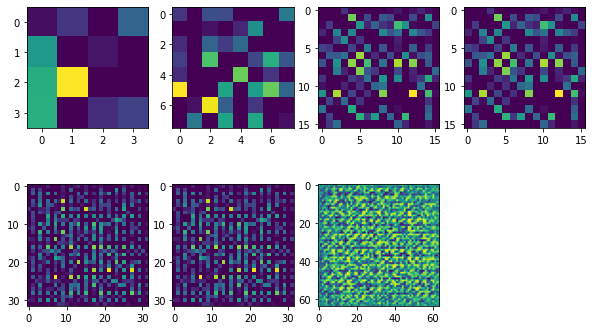

torch.Size([1, 100, 1, 1])
torch.Size([1, 512, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 16, 16])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 3, 64, 64])


In [8]:
# Check Generator
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(feature_dim=100, image_size=64)

input_z = torch.randn(1, 100)

input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

fake_images, attention_maps, layers_outputs = G(input_z)

fig = plt.figure(figsize=(10,6))
for i, layer in enumerate(layers_outputs):
    img_activation = layer[0][0].detach().numpy()
    plt.subplot(2,4,i+1)
    plt.imshow(img_activation)
img_transformed = fake_images[0][0].detach().numpy()
plt.subplot(2,4,7)
plt.imshow(img_transformed)
plt.show()
print(input_z.shape)
for output in layers_outputs:
    print(output.shape)
print(fake_images.shape)

# Discriminator

In [9]:
class Discriminator(nn.Module):

    def __init__(self, feature_dim=100, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(3, image_size, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.self_attention1 = Self_Attention(in_dim=image_size*4)

        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.self_attention2 = Self_Attention(in_dim=image_size*8)

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, feature):
        conv1_out = self.layer1(feature)
        conv2_out = self.layer2(conv1_out)
        conv3_out = self.layer3(conv2_out)
        attention1_out, attention_map1 = self.self_attention1(conv3_out)
        conv4_out = self.layer4(attention1_out)
        attention2_out, attention_map2 = self.self_attention2(conv4_out)
        out = self.last(attention2_out)

        return out, [attention_map1, attention_map2] , [conv1_out,conv2_out,conv3_out,attention1_out,conv4_out,attention2_out]

In [10]:
# Discriminator Check
D = Discriminator(feature_dim=100, image_size=64)

input_z = torch.randn(1, 100)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, _, _ = G(input_z)

d_out, attention_map1, attention_map2 = D(fake_images)

print(nn.Sigmoid()(d_out))

tensor([[[[0.5062]]]], grad_fn=<SigmoidBackward>)


# Data Loader

In [11]:
def make_datapath_list():

    train_img_list = list()

    for i in range(898):
        index = i+1
        if index//10 == 0:
            index_str = f"00{index}"
        elif index/10 < 10:
            index_str = f"0{index}"
        else:
            index_str = str(index)
        img_path = f"./Pokemon_zukan/img{index_str}.png"
        train_img_list.append(img_path)

    return train_img_list

class ImageTransform():

    def __init__(self, size):
        self.data_transform = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.ToTensor(),
        ])

    def __call__(self, img):
        return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
    
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):

        img_path = self.file_list[index]
        img = Image.open(img_path).convert('RGB')

        img_transformed = self.transform(img)

        return img_transformed

In [12]:
train_img_list=make_datapath_list()

size = 64
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(size))

batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size())

torch.Size([32, 3, 64, 64])


In [13]:
def train_model(G, D, dataloader, num_epochs, model_name=None):

    if model_name != None:
      if not os.path.isdir(f"./saved_model/{model_name}"):
        os.makedirs(f"./saved_model/{model_name}")
        os.makedirs(f"./saved_model/{model_name}/CPU/Generator")
        os.makedirs(f"./saved_model/{model_name}/CPU/Discriminator")
        os.makedirs(f"./saved_model/{model_name}/GPU/Generator")
        os.makedirs(f"./saved_model/{model_name}/GPU/Discriminator")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    feature_dim = 100
    mini_batch_size = 32

    G.to(device)
    D.to(device)

    G.train()
    D.train()

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    iteration = 1
    G_logs = []
    D_logs = []

    for epoch in range(num_epochs):

        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0

        print('-----------------')
        print(f"Epoch{epoch}/{num_epochs}")
        print('-----------------')
        print(' (train) ')

        for images in dataloader:
            # If batch size is 0, BatchNormLayer dont work 
            if images.size()[0] == 1:
                continue
            
            images = images.to(device)
            # make label
            mini_batch_size = images.size()[0]

            #######################
            # Discriminator train #
            #######################
            d_out_real, _, _ = D(images)
            # make fake images & predict
            input_feature = torch.randn(mini_batch_size, feature_dim).to(device)
            input_feature = input_feature.view(input_feature.size(0), input_feature.size(1), 1, 1)
            fake_images, _, _ = G(input_feature)
            d_out_fake, _, _ = D(fake_images)
            # calculate loss
            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            d_loss = d_loss_real + d_loss_fake
            # back propagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            ###################
            # Generator train #
            ###################
            # make fake imagaes & predict
            input_feature = torch.randn(mini_batch_size, feature_dim).to(device)
            input_feature = input_feature.view(input_feature.size(0), input_feature.size(1), 1, 1)
            fake_images, _, _ = G(input_feature)
            d_out_fake, _, _ = D(fake_images)
            # calculate loss
            g_loss = - d_out_fake.mean()
            # back propagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            #############
            # Recording #
            #############
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print('-------------')
        print(f"epoch {epoch} || Epoch_D_Loss:{epoch_d_loss/batch_size:.4f} || Epoch_G_Loss:{epoch_g_loss/batch_size:.4f}")
        print(f"timer: {t_epoch_finish - t_epoch_start:.4f}")
        t_epoch_start = time.time()
        G_logs.append(epoch_g_loss/batch_size)
        D_logs.append(epoch_d_loss/batch_size)

        if model_name != None and epoch%20 == 0:
          model_path =  f"./saved_model/{model_name}"
          file_name = f"{epoch}.pth"
          torch.save(G.state_dict(), f"{model_path}/GPU/Generator/{file_name}")
          torch.save(D.state_dict(), f"{model_path}/GPU/Discriminator/{file_name}")
          torch.save(G.to('cpu').state_dict(), f"{model_path}/CPU/Generator/{file_name}")
          torch.save(D.to('cpu').state_dict(), f"{model_path}/CPU/Discriminator/{file_name}")
          G.to(device)
          D.to(device)

    if model_name != None:
          model_path =  f"./saved_model/{model_name}"
          file_name = f"{num_epochs}.pth"
          torch.save(G.state_dict(), f"{model_path}/GPU/Generator/{file_name}")
          torch.save(D.state_dict(), f"{model_path}/GPU/Discriminator/{file_name}")
          torch.save(G.to('cpu').state_dict(), f"{model_path}/CPU/Generator/{file_name}")
          torch.save(D.to('cpu').state_dict(), f"{model_path}/CPU/Discriminator/{file_name}")
          G.to(device)
          D.to(device)
    return G, D

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G.apply(weights_init)
D.apply(weights_init)

print("Network initialize completed")

Network initialize completed


# Training

In [15]:
num_epochs = 500
G_update, D_update = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs,model_name="SAGAN")

Using device: cuda:0
-----------------
Epoch0/500
-----------------
 (train) 
-------------
epoch 0 || Epoch_D_Loss:0.7737 || Epoch_G_Loss:1.1086
timer: 178.4826
-----------------
Epoch1/500
-----------------
 (train) 
-------------
epoch 1 || Epoch_D_Loss:0.7957 || Epoch_G_Loss:0.4774
timer: 9.1722
-----------------
Epoch2/500
-----------------
 (train) 
-------------
epoch 2 || Epoch_D_Loss:0.4082 || Epoch_G_Loss:1.0628
timer: 9.2065
-----------------
Epoch3/500
-----------------
 (train) 
-------------
epoch 3 || Epoch_D_Loss:0.4959 || Epoch_G_Loss:1.3191
timer: 9.0244
-----------------
Epoch4/500
-----------------
 (train) 
-------------
epoch 4 || Epoch_D_Loss:0.7366 || Epoch_G_Loss:1.1132
timer: 8.9832
-----------------
Epoch5/500
-----------------
 (train) 
-------------
epoch 5 || Epoch_D_Loss:0.8688 || Epoch_G_Loss:0.9988
timer: 9.0351
-----------------
Epoch6/500
-----------------
 (train) 
-------------
epoch 6 || Epoch_D_Loss:1.1494 || Epoch_G_Loss:0.7237
timer: 9.0535
----

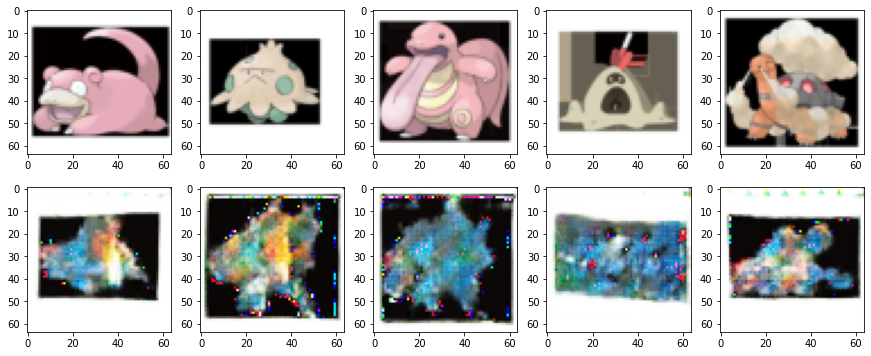

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 32
feature_dim = 100
fixed_z = torch.randn(batch_size, feature_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

G_update.eval()
fake_images, am1, am2 = G_update(fixed_z.to(device))

batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

fig = plt.figure(figsize=(15,6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    img = transforms.functional.to_pil_image(images[i])
    plt.imshow(img)

    plt.subplot(2, 5, 5+i+1)
    fake_img = transforms.functional.to_pil_image(fake_images[i])
    plt.imshow(fake_img)
    fake_img.save(f"./out/image_generated/64SAGAN{i+5}.png",quality=95)